***Seam Carving***


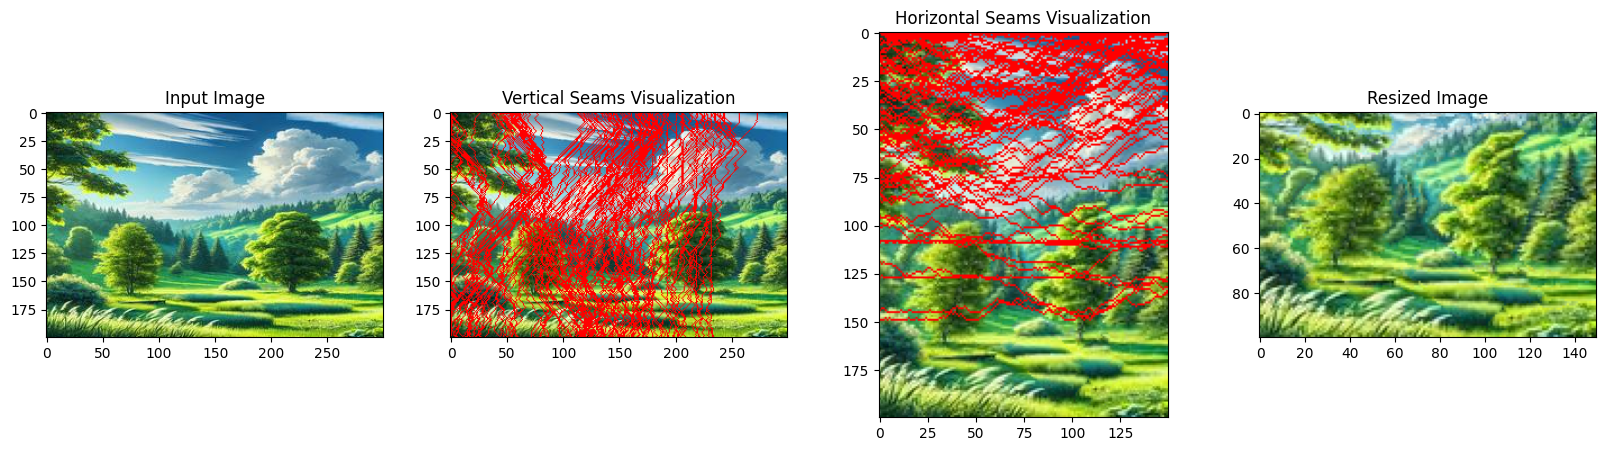

In [6]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Calculate energy using Sobel gradient
def calculate_energy(image):
    gray = np.mean(image, axis=2)  # Convert to grayscale
    dx = np.zeros_like(gray)
    dy = np.zeros_like(gray)

    dx[:, 1:-1] = gray[:, 2:] - gray[:, :-2]
    dy[1:-1, :] = gray[2:, :] - gray[:-2, :]

    energy = np.abs(dx) + np.abs(dy)
    return energy

# Compute cumulative energy map
def compute_cumulative_energy(energy):
    rows, cols = energy.shape
    cum_energy = energy.copy()
    for i in range(1, rows):
        for j in range(cols):
            left = cum_energy[i - 1, j - 1] if j > 0 else float('inf')
            up = cum_energy[i - 1, j]
            right = cum_energy[i - 1, j + 1] if j < cols - 1 else float('inf')
            cum_energy[i, j] += min(left, up, right)
    return cum_energy

# Find the seam to remove
def find_seam(cum_energy):
    rows, cols = cum_energy.shape
    seam = np.zeros(rows, dtype=np.int32)
    seam[-1] = np.argmin(cum_energy[-1])  # Start at the bottom row

    for i in range(rows - 2, -1, -1):  # Trace back to the top row
        prev_col = seam[i + 1]
        col_start = max(prev_col - 1, 0)  # Ensure we don't go out of bounds
        col_end = min(prev_col + 2, cols)  # Ensure we don't go out of bounds
        offset = np.argmin(cum_energy[i, col_start:col_end])  # Find minimum in the valid range
        seam[i] = col_start + offset  # Map the offset back to the correct column index

    return seam

# Visualize seam
def visualize_seam(image, seam):
    image_with_seam = image.copy()
    for i in range(len(seam)):
        image_with_seam[i, seam[i]] = [255, 0, 0]  # Mark the seam in red
    return image_with_seam

# Remove seam
def remove_seam(image, seam):
    rows, cols, _ = image.shape
    new_image = np.zeros((rows, cols - 1, 3), dtype=image.dtype)
    for i in range(rows):
        new_image[i, :, :] = np.delete(image[i, :, :], seam[i], axis=0)
    return new_image

# Main seam carving function
def seam_carve(image, target_width, target_height):
    current_image = image.copy()
    vertical_seams_visualization = image.copy()

    # Resize width
    while current_image.shape[1] > target_width:
        energy = calculate_energy(current_image)
        cum_energy = compute_cumulative_energy(energy)
        seam = find_seam(cum_energy)
        vertical_seams_visualization = visualize_seam(vertical_seams_visualization, seam)
        current_image = remove_seam(current_image, seam)

    # Resize height
    horizontal_seams_visualization = np.transpose(current_image, (1, 0, 2))
    current_image = np.transpose(current_image, (1, 0, 2))

    while current_image.shape[1] > target_height:
        energy = calculate_energy(current_image)
        cum_energy = compute_cumulative_energy(energy)
        seam = find_seam(cum_energy)
        horizontal_seams_visualization = visualize_seam(horizontal_seams_visualization, seam)
        current_image = remove_seam(current_image, seam)

    current_image = np.transpose(current_image, (1, 0, 2))
    horizontal_seams_visualization = np.transpose(horizontal_seams_visualization, (1, 0, 2))

    return vertical_seams_visualization, horizontal_seams_visualization, current_image

# Main function
def main():
    input_name = "small_green_landscape.jpg"
    input_image = np.array(Image.open(input_name))

    target_width = input_image.shape[1] // 2
    target_height = input_image.shape[0] // 2

    vertical_seams_image, horizontal_seams_image, resized_image = seam_carve(input_image, target_width, target_height)

    # Save results
    Image.fromarray(vertical_seams_image.astype(np.uint8)).save('vertical_seams_image.jpg')
    Image.fromarray(horizontal_seams_image.astype(np.uint8)).save('horizontal_seams_image.jpg')
    Image.fromarray(resized_image.astype(np.uint8)).save('resized_image.jpg')

    # Display results
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.title('Input Image')
    plt.imshow(input_image)

    plt.subplot(1, 4, 2)
    plt.title('Vertical Seams Visualization')
    plt.imshow(vertical_seams_image)

    plt.subplot(1, 4, 3)
    plt.title('Horizontal Seams Visualization')
    plt.imshow(horizontal_seams_image)

    plt.subplot(1, 4, 4)
    plt.title('Resized Image')
    plt.imshow(resized_image)

    plt.show()

main()
